## Introduction
In this document, we will train two new models, investigating first the relation between salary expectation and the topicality of a job offer, then  if the location of a job offer can have an effect on its topicality. Again, as mentioned in the past, the results here have no statistical validity whatsoever and are meant to be only an example of an application of stm.

## Data preparation - salaries
A first challenge concerns the type of data available, as the salary data we managed to extrapolate from ideed.co.uk are computed by different temporal factors (year/month/week/day/hour), and for some are given only a single value while for others a range. We then try here to identify on which percentile each salary falls (taking the average value for the salary ranges), based on the data of the <a href="https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/allemployeesashetable1">UK Office for National Statistics  </a>. For the sake of simplicity, we then group the results in just three groups - below average (up to the 40th percentile), average (from 40th to 60th) and above average.  Unfortunately the data are available only for year, hour and week, so we have to exclude the salaries with day and month factor. 

In [1]:
salaries<-read.csv2("salaries.csv", sep=";")# data from https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/allemployeesashetable1
salaries[,3:13]<-as.numeric(as.character(unlist(salaries[,3:13])))#be sure that data are seen as numeric

DFa<-read.table("totaljobsCoordRates.txt")
DF<-DFa[!is.na(DFa$Description),]#get rid of entries with no description...
DF<-DF[!is.na(DF$rateby),]#...or temporal rate 
DF$salaryavg<-(DF$minrate+DF$maxrate)/2#consider average values for rates
DF$perc=NA
DF$is.part<-as.numeric(grepl("Part-time", DF$Type))#dummy variable is offer is part time


ratefactors<-as.character(unique(DF$rateby))#identify rate factors

lbls = c(1,2,2.5,3,4,5,6,7,7.5,8,9,10)#percentiles included in the ONS dataset

#next we identify the breaks according to temporal factor and if part or full time
breaksPartYear<-c(0, as.numeric(sort(salaries[6,3:13])), Inf)
breaksFullYear<-c(0, as.numeric(sort(salaries[5,3:13])), Inf)
breaksPartHour<-c(0, as.numeric(sort(salaries[4,3:13])), Inf)
breaksFullHour<-c(0, as.numeric(sort(salaries[3,3:13])), Inf)
breaksPartWeek<-c(0, as.numeric(sort(salaries[2,3:13])), Inf)
breaksFullWeek<-c(0, as.numeric(sort(salaries[1,3:13])), Inf)

#then we identify on which percentile the salary falls
DF[which (DF$is.part==TRUE  & DF$rateby==ratefactors[1]),]$perc<-
  as.numeric(as.vector(cut(DF[which (DF$is.part==TRUE  & DF$rateby==ratefactors[1]),]$salaryavg, breaks=breaksPartYear, right=FALSE, labels = lbls)))
DF[which (DF$is.part==FALSE  & DF$rateby==ratefactors[1]),]$perc<-
  as.numeric(as.vector(cut(DF[which (DF$is.part==FALSE  & DF$rateby==ratefactors[1]),]$salaryavg, breaks=breaksFullYear, right=FALSE, labels = lbls)))

DF[which (DF$is.part==TRUE  & DF$rateby==ratefactors[2]),]$perc<-
  as.numeric(as.vector(cut(DF[which (DF$is.part==TRUE  & DF$rateby==ratefactors[2]),]$salaryavg, breaks=breaksPartHour, right=FALSE, labels = lbls)))
DF[which (DF$is.part==FALSE  & DF$rateby==ratefactors[2]),]$perc<-
  as.numeric(as.vector(cut(DF[which (DF$is.part==FALSE  & DF$rateby==ratefactors[2]),]$salaryavg, breaks=breaksFullHour, right=FALSE, labels = lbls)))

DF[which (DF$is.part==TRUE  & DF$rateby==ratefactors[3]),]$perc<-
  as.numeric(as.vector(cut(DF[which (DF$is.part==TRUE  & DF$rateby==ratefactors[3]),]$salaryavg, breaks=breaksPartWeek, right=FALSE, labels = lbls)))
DF[which (DF$is.part==FALSE  & DF$rateby==ratefactors[3]),]$perc<-
  as.numeric(as.vector(cut(DF[which (DF$is.part==FALSE  & DF$rateby==ratefactors[3]),]$salaryavg, breaks=breaksFullWeek, right=FALSE, labels = lbls)))

DF<-DF[!is.na(DF$perc),]#get rid of no entries missing data

#simplify the percentiles to just three levels
simlbls<-c("below", "avg", "above")
DF$salexp<-cut(DF$perc, breaks=c(0,4,6,10), labels=simlbls)

DF$is.part<-as.factor(DF$is.part)#dummy for part time is seen as factor

DF$percF<-as.factor(DF$perc)#create a column with percentile as factor just in case

We can see that the distribution of the salaries in our (again, not statistically representative) sample doesn't follow the national one, which can be explained, among other things, considering that indeed.co.uk tend to have less postings for qualified job offers:

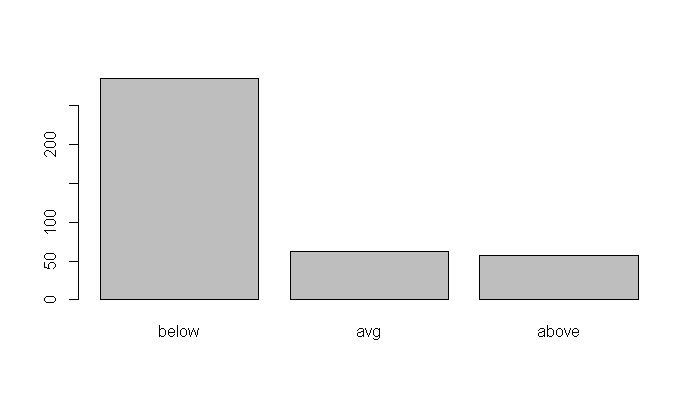

In [2]:
options(repr.plot.width=7, repr.plot.height=4, repr.plot.res=100)
plot(DF$salexp)

## Model preparation and analysis
We can next move to the model preparation. We have seen in detail a workflow for this purpose in the previous post, so this time we will just focus on a model with 20 topics. Compared to our last attempt, here we will exclude some recurring stopwords with little semantic content.

In [3]:
suppressWarnings(library(stm))
suppressWarnings(library(stringr))
DF$Description = str_replace_all(DF$Description, "/"," ")# replace "/" with a space  
DF$Description = str_replace_all(DF$Description, "&#x27;|&quot;|&#x2F;", "'") ## links and other eventual html encoding (adapted from https://juliasilge.com/blog/evaluating-stm/)
DF$Description = str_replace_all(DF$Description, "<a(.*?)>", " ")             ## 
DF$Description = str_replace_all(DF$Description, "&gt;|&lt;|&amp;", " ")      ##
DF$Description = str_replace_all(DF$Description, "&#[:digit:]+;", " ")        ##
DF$Description = str_remove_all(DF$Description, "<[^>]*>")

processed<-textProcessor(DF$Description, metadata = DF, customstopwords=c("work", "will", "ll", "re", "just" ),verbose=FALSE)

out<-prepDocuments(processed$documents, processed$vocab, processed$meta, verbose=FALSE)

model20<-stm(documents=out$documents, 
                          vocab=out$vocab, prevalence=~ salexp+is.part, K=20, data=out$meta, init.type = "Spectral", verbose=FALSE)

stm v1.3.3 (2018-1-26) successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com


We familiarize a bit with the model, exploring the distribution of $\theta$ and $\beta$ values and the topics content: 


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



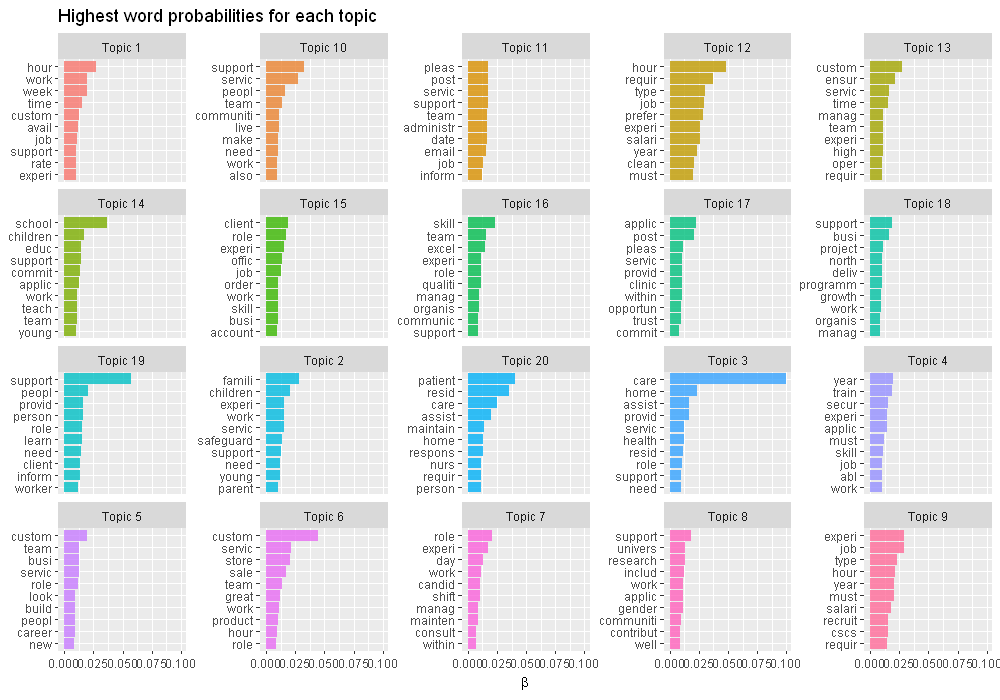

In [4]:
suppressWarnings(library(drlib))#drlib is available on github and needs devtools to be installed
suppressWarnings(library(dplyr))
suppressWarnings(library(tidytext))
suppressWarnings(library(ggplot2))

td_theta20 <- tidytext::tidy(model20, matrix = "theta")
td_beta20 <- tidytext::tidy(model20, matrix = "beta")

options(repr.plot.width=10, repr.plot.height=7)

td_beta20 %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  ungroup() %>%
  mutate(topic = paste0("Topic ", topic),
         term = reorder_within(term, beta, topic)) %>%
  ggplot(aes(term, beta, fill = as.factor(topic))) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free_y") +
  coord_flip() +
  scale_x_reordered() +
  labs(x = NULL, y = expression(beta),
       title = "Highest word probabilities for each topic"
  )

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


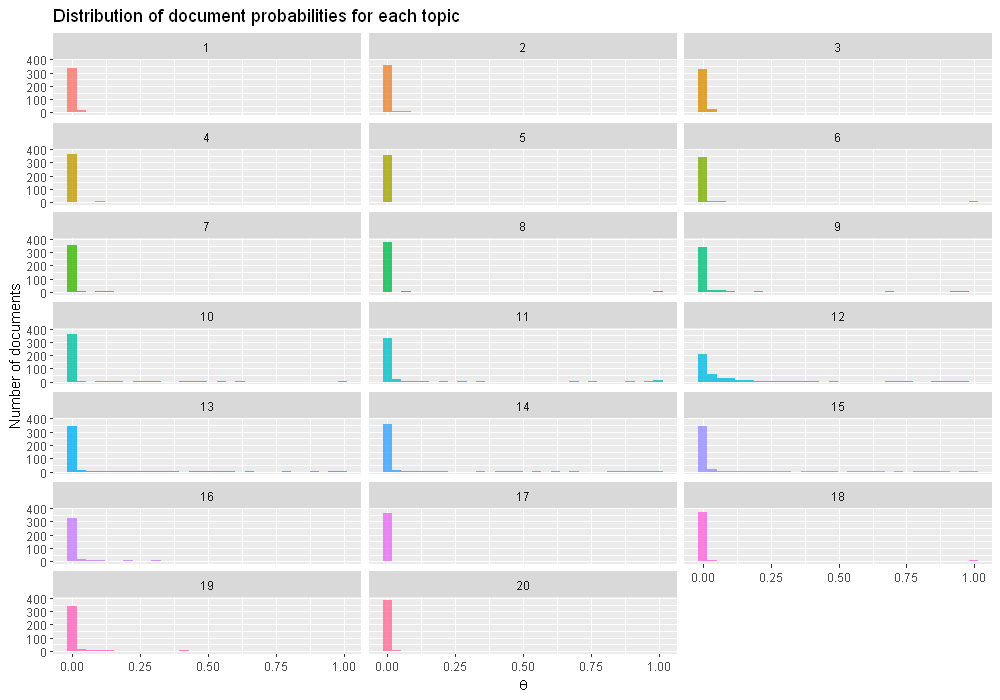

In [5]:
ggplot(td_theta20, aes(gamma, fill = as.factor(topic))) +
  geom_histogram(alpha = 0.8, show.legend = FALSE) +
  facet_wrap(~ topic, ncol = 3) +
  labs(title = "Distribution of document probabilities for each topic",
       y = "Number of documents", x = expression(theta))

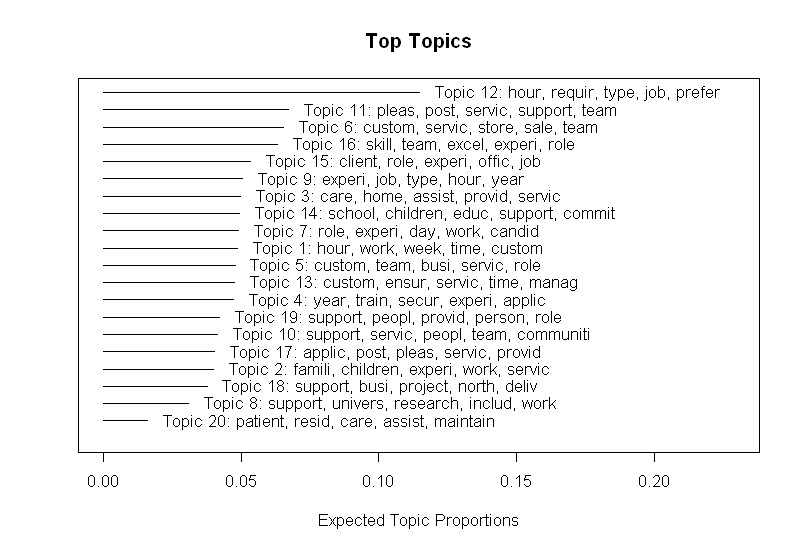

In [6]:
options(repr.plot.width=8, repr.plot.height=5.5, repr.plot.res=100)
plot.STM(model20, "summary", n=5)# distribution and top 5 words per topic

We move next to explore the relation between the salary expectation and the topicality of a job offer. The most immediate way to answer the question is to estimate a regression with the topic proportions as outcome variable and the percentile as a predictor (controlling for other variables), running the built-in <span style="font-family:Courier">estimateEffect</span> function. We see here as an example the results of the regression on topic 17 controlling for part time: 

In [7]:
prep<-estimateEffect(1:20~ salexp+is.part, model20, meta=out$meta, uncertainty="Global", nsims=200)
sumprep<-summary(prep)
sumprep$tables[[17]]

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.01656139,0.009604771,1.724288,8.542843e-02
salexpavg,0.05803120,0.024346427,2.383561,1.761182e-02
salexpabove,0.13948027,0.030051833,4.641323,4.700174e-06
is.part1,-0.03032214,0.020741699,-1.461893,1.445557e-01


The results can then be plotted with <span style="font-family:Courier">plot.estimateEffect</span>. This allows to visually understand the effect of a covariate (in this case, the salary level on the job offer) on the expected topic proportion. Here we see for example topics 17 and 12:

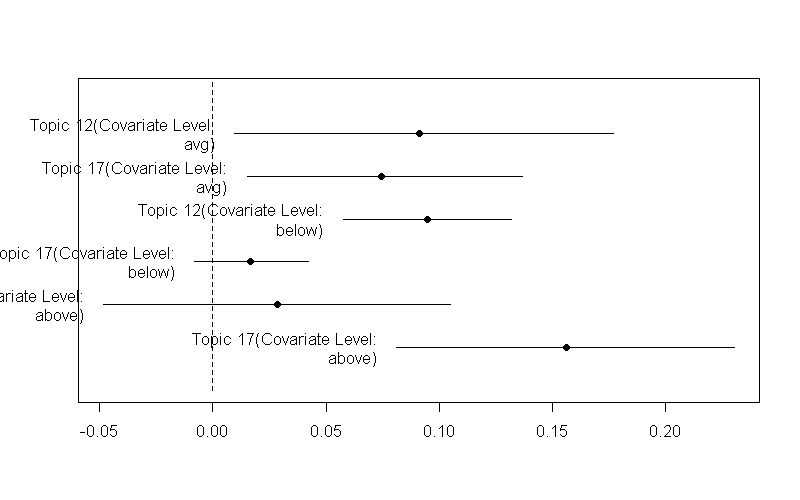

In [8]:
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res=100)
plot.estimateEffect(prep, model=model20, covariate="salexp", topics=c(12,17), nsims = 100, ci.level=.99)#

We see significant effects for topic 17 from salaries above average, while in offers with salaries below average we can expect a representation higher than average of topic 12 (offers with average salaries have also significant effects on both topics). Topic 17 appears to be related to offers for qualified health professionals, and 12 to be related to manual jobs like cleaning, driving and warehousing, hence the results make empirical sense:

In [9]:
labelTopics(model20, n=10, topics=c(12,17))

Topic 12 Top Words:
 	 Highest Prob: hour, requir, type, job, prefer, experi, salari, year, clean, must 
 	 FREX: clean, prefer, licens, licenc, drive, driver, temporari, type, hour, full-tim 
 	 Lift: avenu, tachograph, cpc, hoover, moor, temp, hartlepool, blaydon, iron, empti 
 	 Score: clean, driver, prefer, cleaner, temporari, preferredlic, licens, part-tim, licenc, saturday 
Topic 17 Top Words:
 	 Highest Prob: applic, post, pleas, servic, provid, clinic, within, opportun, trust, commit 
 	 FREX: trust, clinic, nhs, colleg, hospit, post, psycholog, cancer, foundat, medic 
 	 Lift: derwentsid, gynaecolog, irrespect, outpati, profess, trustwid, -repres, “employ, “healthcar, burn 
 	 Score: clinic, nhs, psycholog, trust, colleg, derwentsid, cancer, maxxima, teach, hospit 

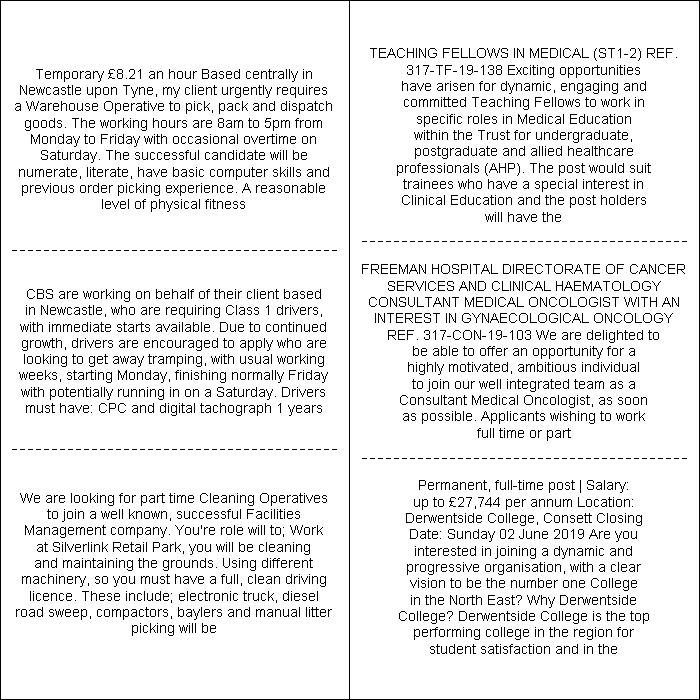

In [10]:
thoughts12 <- findThoughts(model20,texts=DF$Description, topics=12, n=3)$docs[[1]] 
thoughts17 <- findThoughts(model20,texts=DF$Description, topics=17, n=3)$docs[[1]]

options(repr.plot.width=7, repr.plot.height=7, repr.plot.res=100)
par(mfrow=c(1,2), mar=c(0,0,0,0))

plotQuote(thoughts12,width=50, maxwidth=400, text.cex=.85)
plotQuote(thoughts17,width=40, maxwidth=400, text.cex=.85)

## Another example - spatial dummy variable
We see here a different example, this time based on a spatial dummy variable (I drew inspiration for this from <a href="https://www.tandfonline.com/doi/full/10.1080/1369118X.2016.1218528?scroll=top&needAccess=true">a study  by Sonya Sachdeva et al.   </a>about tweets as an element to model wildfire dispertion). Spatial modelling is not really possible as of now within stm, however some rudimentary solutions can be devised with the use of dummy variables. Here as an example we try to see if being located in Newcastle Upon Tyne has any influence on the topicality of a job offer. We create a dummy variable and then train a new model of 20 topics:

In [11]:
DF$isnewcastle<-as.numeric(DF$Location=="Newcastle upon Tyne")

In [12]:
processed2<-textProcessor(DF$Description, metadata = DF, customstopwords=c("work", "will", "ll", "re", "just" ), verbose=FALSE)

out2<-prepDocuments(processed2$documents, processed2$vocab, processed2$meta, verbose=FALSE)

model20b<-stm(documents=out2$documents, 
                          vocab=out2$vocab, prevalence=~ salexp+is.part+isnewcastle, K=20, data=out2$meta, init.type = "Spectral", verbose=FALSE)

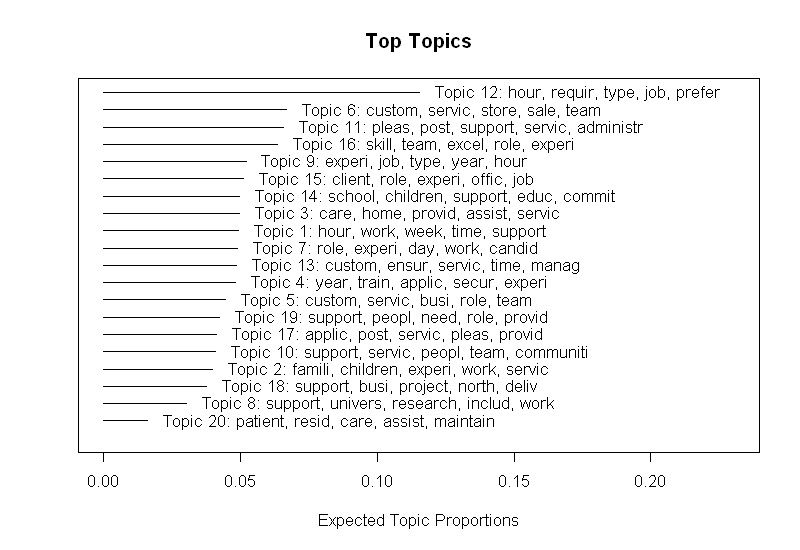

In [13]:
options(repr.plot.width=8, repr.plot.height=5.5, repr.plot.res=100)
plot.STM(model20b, "summary", n=5)# distribution and top 5 words per topic

We then run a new regression and plot the results. As this time the variable is binary, we can use the "difference" method of <span style="font-family:Courier">plot.estimateEffect</span>, which estimates the mean difference in topic proportions for two different values of the covariate: 

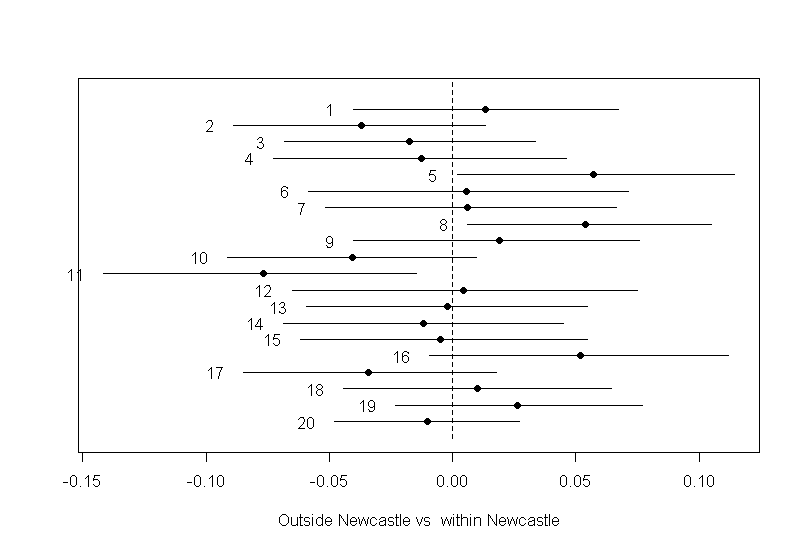

In [14]:
prep2<-estimateEffect(1:20~ isnewcastle+salexp+is.part, model20b, meta=out2$meta, uncertainty="Global", nsims=200)

plot.estimateEffect(prep2, model=model20b, cov.value1="1", cov.value2="0", covariate="isnewcastle", topics=c(1:20), method="difference",
                        nsims = 100, xlab="Outside Newcastle vs  within Newcastle", labeltype="custom", custom.labels=c(1:20),ci.level=.99)

At a confidence interval of 99% we can notice how the location has some significant effects for topics 8, 5 and 11. Topic 5 appears related to sales and customer care, while Topic 11 seems to be relative to administrative jobs; explaining the effect of location on their topicality would require some additional investigation. However, topic 8 appears related to University and research positions, so it makes sense that this topic is more likely to appear in job offers in Newcastle, which is seat of two Universities. 

In [15]:
labelTopics(model20b, n=10, topics=c(5,8,11))

Topic 5 Top Words:
 	 Highest Prob: custom, servic, busi, role, team, look, build, career, new, day 
 	 FREX: kitchen, test, youll, career, want, softwar, survey, autom, retail, know 
 	 Lift: promis, dilapid, fair, laser, massiv, mric, perk, tech, tester, -star 
 	 Score: survey, laser, kitchen, surveyor, promis, autom, water, tester, custom, youll 
Topic 8 Top Words:
 	 Highest Prob: support, univers, research, includ, work, applic, gender, contribut, well, equal 
 	 FREX: univers, gender, research, intellig, sex, sexual, regardless, orient, marit, race 
 	 Lift: librari, metal, wwwnclacuk, archaeolog, athena, berri, euraxess, everybodi, intellig, kingfish 
 	 Score: gender, univers, marit, research, intellig, everybodi, sexual, ethnic, pregnanc, archaeolog 
Topic 11 Top Words:
 	 Highest Prob: pleas, post, support, servic, administr, date, team, email, inform, job 
 	 FREX: counti, email, council, short-list, advert, administr, invit, grade, date, note 
 	 Lift: answerphon, chronolo

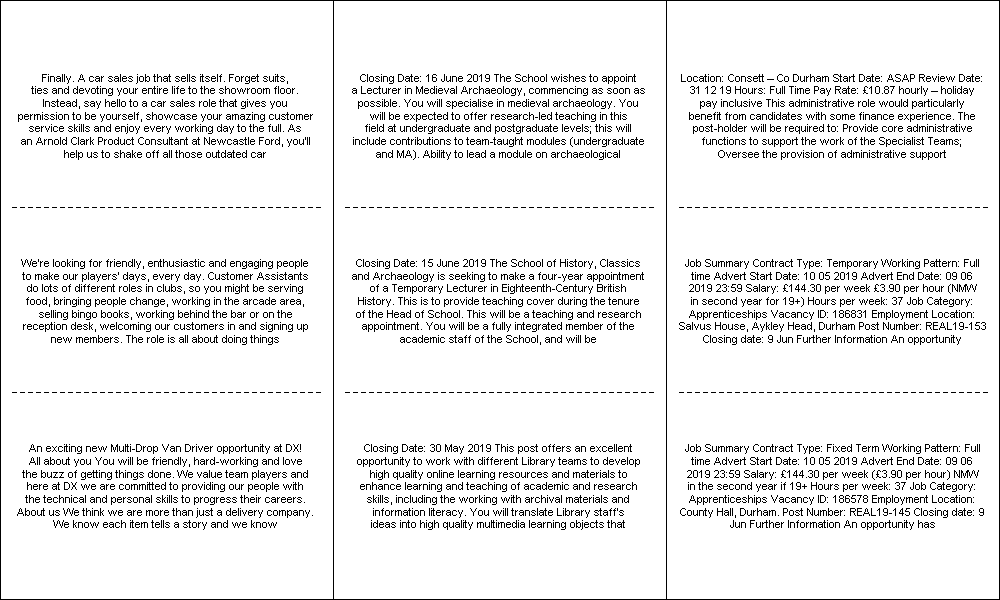

In [16]:
thoughts5b <- findThoughts(model20,texts=DF$Description, topics=5, n=3)$docs[[1]] 
thoughts8b <- findThoughts(model20,texts=DF$Description, topics=8, n=3)$docs[[1]]
thoughts11b <- findThoughts(model20,texts=DF$Description, topics=11, n=3)$docs[[1]]

options(repr.plot.width=10, repr.plot.height=6, repr.plot.res=100)
par(mfrow=c(1,3), mar=c(0,0,0,0))

plotQuote(thoughts5b,width=60, maxwidth=400, text.cex=1)
plotQuote(thoughts8b,width=60, maxwidth=400, text.cex=1)
plotQuote(thoughts11b,width=60, maxwidth=400, text.cex=1)

## Conclusions
In this document, we have seen some possible applications of the structural topic model for the analysis of relationships between document metadata and the topics in the documents. 
We have seen as an example how offers with salaries above average tend to have a higher representation of a topic related to qualified health positions, and those with lower salaries of topics related to manual jobs. 
In another example, we have seen how offers in Newcastle can be expected to have a higher representation of the topic relative to university and research. 

As mentioned, the results presented here don't have statistical value, and the examples mentioned are relatively trivial: they are to be considered only as an example of the use of the model and its R implementation, and of the type of investigations that can be conducted with the model. The stm package offers a flexible platform for the investigation of metadata and topics, and as shown by the list of studies adopting it available on the page of the developers of the model, whilst its main use so far has been in social/political human sciences other applications are possible and promising. 